<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 3
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Ensambles: XGBoost

XGBoost utiliza el principio de boosting, que genera múltiples modelos de predicción “débiles” secuencialmente, y cada uno de estos toma los resultados del modelo anterior para generar un modelo más “fuerte”, con mejor poder predictivo y mayor estabilidad en sus resultados

## Carga inicial de dependencias y datos

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#modelos y métricas
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score,f1_score, precision_score, make_scorer, confusion_matrix

#preprocesamiento
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

In [262]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

# renombrar columna del dataframe de reserved_room_type a room_type_match
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False

hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

In [263]:
hotels_df = hotels_df_mod.copy()
hotels_df_backup = hotels_df.copy()

In [264]:
hotels_df_x = pd.get_dummies(hotels_df, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

hotels_df_x = hotels_df_x.drop(['is_canceled'], axis='columns')

hotels_df_x = hotels_df_x.reindex(sorted(hotels_df_x.columns), axis=1)

hotels_df_y = hotels_df['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotels_df_x,
                                                    hotels_df_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

## Se buscan los hiperparámetros con GridSearch CV

Para encontrar los hiperparámetros que mejor se ajusten al modelo, se utiliza GridSearch CV, que prueba todas las combinaciones posibles de los hiperparámetros que se le pasan, y devuelve la combinación que mejor resultado obtuvo.  
Antes de realizar esto, vale aclarar que se realizaron pruebas aleatorias manuales para encontrar intervalos más reducidos a probar, de forma que no resulta tan extenso el tiempo de ejecución de GridSearch CV.

Los hiperparámetros que se tuvieron en cuenta fueron:

* learning_rate: tasa de aprendizaje
* max_depth: máxima profundidad de cada árbol
* subsample: porcentaje de muestras usadas para cada árbol (valores muy bajo lleva a un posible underfitting)
* colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto llevan a un posible overfitting)
* n_estimators: cantidad de árboles a construir.


In [265]:
xgb_model = xgb.XGBClassifier(random_state=0, n_jobs=-1)

param_grid = { "max_depth" : [8,10,12], 
               "subsample" : [0.6, 0.7], 
               "colsample_bytree" : [0.5, 0.6], 
               "n_estimators": [150, 200, 250, 350, 400],
                "learning_rate": [0.1]}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=xgb_model, 
                               param_grid=param_grid, 
                               scoring=scorer_fn, 
                               refit=False, 
                               cv=kfoldcv, 
                               n_jobs=-1)

xgb_model = gridcv.fit(X = x_train, y = y_train)

In [266]:
print(gridcv.best_params_)
print(gridcv.best_score_)

{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400, 'subsample': 0.7}
0.8643335497972406


A partir de estos parámetros, se entrenó el modelo:

In [295]:
xgb_model = xgb.XGBClassifier(
                                random_state=0,
                                subsample=0.7,
                                colsample_bytree=0.6, 
                                n_estimators=400, 
                                max_depth=10,
                                learning_rate=0.1, 
                                n_jobs=-1)
xgb_model.fit(x_train, y_train)
y_pred=xgb_model.predict(x_test)

accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Test Accuracy: "+str(accuracy))
print("Test Recall: "+str(recall))
print("Test Precision: "+str(precision))
print("Test F1 Score: "+str(f1))

y_train_pred=xgb_model.predict(x_train)

accuracy=accuracy_score(y_train,y_train_pred)
recall=recall_score(y_train,y_train_pred)
precision=precision_score(y_train,y_train_pred)
f1=f1_score(y_train,y_train_pred)

print("Train Accuracy: "+str(accuracy))
print("Train Recall: "+str(recall))
print("Train Precision: "+str(precision))
print("Train F1 Score: "+str(f1))



Accuracy: 0.8628478789516347
Recall: 0.8679835924006909
Precision: 0.8594484822573749
F1 Score: 0.8636949516648764


AUC: 0.9455895471465586
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      9241
           1       0.86      0.87      0.86      9264

    accuracy                           0.86     18505
   macro avg       0.86      0.86      0.86     18505
weighted avg       0.86      0.86      0.86     18505



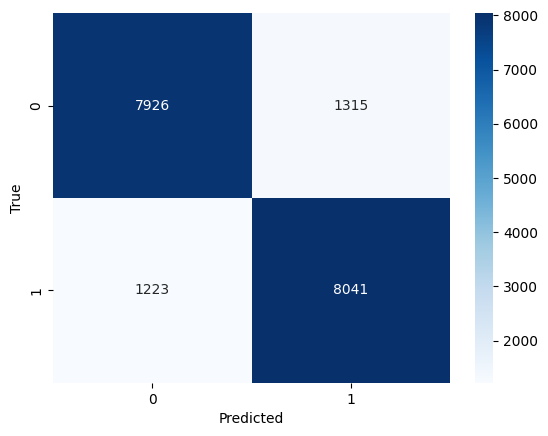

In [292]:
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [287]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

#Transformación de variables numéricas a booleanas 
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False

test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
test_df_mod['agent'] = test_df_mod['agent'].astype(str)
test_df_mod['agent'] = test_df_mod['agent'].replace('nan', 'Undefined')


id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns')


In [288]:
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

In [289]:
#Se crean las columnas que están en el df para entrenar pero no en el df a precedir
for col in hotels_df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in hotels_df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [290]:
#Realizamos una predicción sobre el set de test
y_pred = xgb_model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred

predictions.to_csv('sample_submission.csv', index=False)